<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/17_Cats_vs_Dogs_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsummary
!pip install tqdm
!pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Kaggle's Cats vs Dogs**
Download our cats vs dogs dataset. Should talk around 15-20 seconds.
Source - https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
From (redirected): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t&uuid=33ba8405-9f69-48dd-aad4-f7dbd8f8f286
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:14<00:00, 59.1MB/s]


In [ ]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [ ]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [ ]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.5451.jpg


#### **Create our transformations**

In [ ]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

## **Create a Dataset class that stores our dataset information (paths, labels and transformations**

This object can then be utilzied by torch functions such as `torch.utils.data.random_split`

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [ ]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [ ]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

### **Using our dataset Object**

In [ ]:
# Getting a data entry
train.__getitem__(0)

(tensor([[[0.8431, 0.7647, 0.8157,  ..., 0.7255, 0.7255, 0.6588],
          [0.8353, 0.7725, 0.8196,  ..., 0.7608, 0.6902, 0.7020],
          [0.8039, 0.8510, 0.8471,  ..., 0.7647, 0.7059, 0.8275],
          ...,
          [0.4941, 0.4667, 0.4745,  ..., 0.8431, 0.8118, 0.7569],
          [0.4902, 0.4941, 0.4784,  ..., 0.6863, 0.7647, 0.7843],
          [0.4157, 0.4980, 0.4431,  ..., 0.6706, 0.7804, 0.7490]],
 
         [[0.8784, 0.8000, 0.8510,  ..., 0.7569, 0.7451, 0.6745],
          [0.8706, 0.8078, 0.8549,  ..., 0.7922, 0.7255, 0.7294],
          [0.8275, 0.8745, 0.8824,  ..., 0.7882, 0.7412, 0.8627],
          ...,
          [0.5294, 0.4902, 0.5098,  ..., 0.8275, 0.8000, 0.7451],
          [0.5176, 0.5216, 0.5176,  ..., 0.6667, 0.7490, 0.7686],
          [0.4706, 0.5490, 0.4863,  ..., 0.6549, 0.7647, 0.7216]],
 
         [[0.9137, 0.8353, 0.8824,  ..., 0.7725, 0.7686, 0.6980],
          [0.9059, 0.8392, 0.8863,  ..., 0.8078, 0.7451, 0.7529],
          [0.8471, 0.8980, 0.8980,  ...,

In [ ]:
# Getting the shape of a single image
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


## **Using our dataset object to create our train, validation split**

In [ ]:
train, val = torch.utils.data.random_split(train,[20000,5000])

In [ ]:
# Getting a size of our
print(len(train))
print(len(val))

20000
5000


In [ ]:
# Let's create an array of our labels
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

<Axes: ylabel='count'>

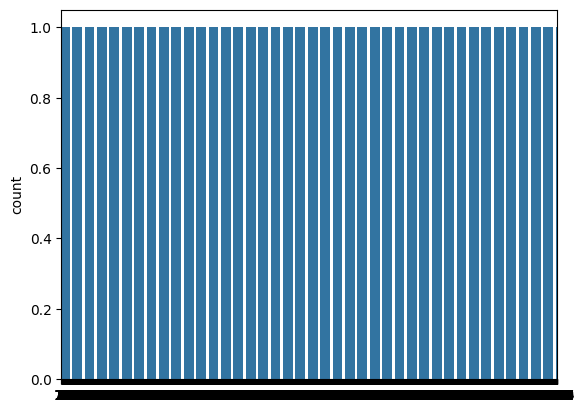

In [ ]:
import seaborn as sns

sns.countplot(val_set_class_count)

## **Dataloaders - let's create our iterable over a dataset**

In [ ]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

### **Use it to get some sample images**

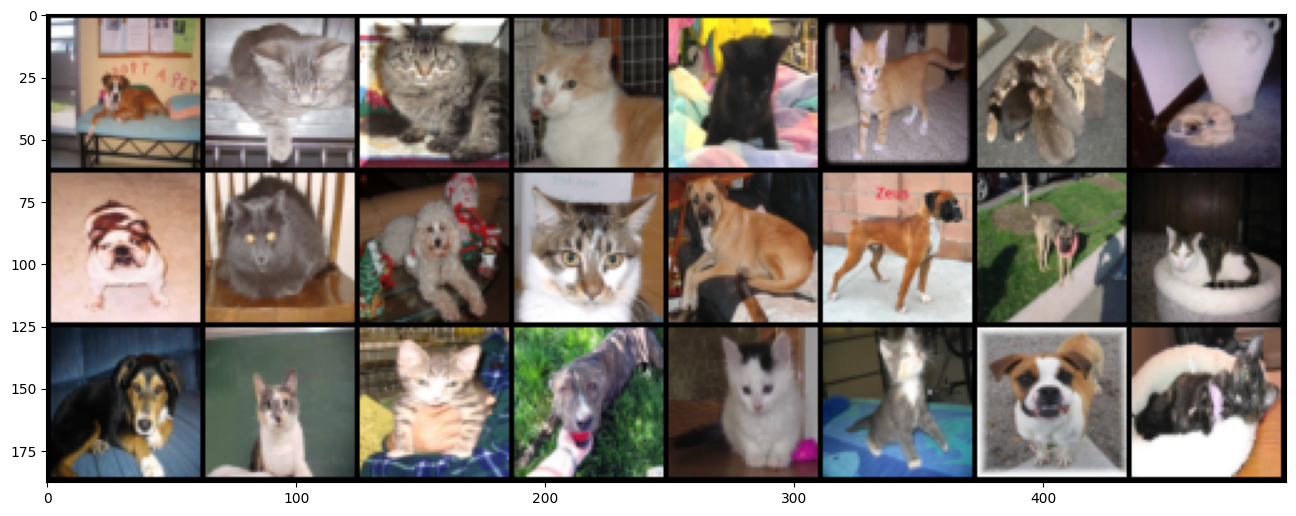

In [ ]:
# samples, labels = iter(train_dataset).next()
# plt.figure(figsize=(16,24))
# grid_imgs = torchvision.utils.make_grid(samples[:24])
# np_grid_imgs = grid_imgs.numpy()

# # in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
# plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
# Fix: Use next() function or .__next__()
samples, labels = next(iter(train_dataset))  # Preferred way
# OR: samples, labels = iter(train_dataset).__next__()

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# Transpose for displaying the image
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))
plt.show()  # Optional: explicitly display the plot

**Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            )

        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )

        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

### **Using TorchSummary to display a Keras style summary output**

`summary(your_model, input_size=(channels, H, W))`

In [ ]:
model = CNN()
# model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

### **Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss
2. We use the Adam Optimization Descent Algorithm - we also specify a learn rate (LR) of 0.0005.
3. Set our epochs to 50

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

## **Train our Model**

**We use TQDM to perform a keras style training**


In [ ]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step()

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-25-73a58f4d551d>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.59565
Epoch 1 Training Loss = 20.999569456481932
Epoch 1 Validation Accuracy = 0.6998
Epoch 1 Validation Loss = 18.853396446082243


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.7145
Epoch 2 Training Loss = 18.553901086425782
Epoch 2 Validation Accuracy = 0.7286
Epoch 2 Validation Loss = 17.994370749042293


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7435
Epoch 3 Training Loss = 17.721014553833008
Epoch 3 Validation Accuracy = 0.7464
Epoch 3 Validation Loss = 17.50986549049426


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.7654
Epoch 4 Training Loss = 17.11855936126709
Epoch 4 Validation Accuracy = 0.772
Epoch 4 Validation Loss = 16.81704301287414


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.787
Epoch 5 Training Loss = 16.51883082733154
Epoch 5 Validation Accuracy = 0.7728
Epoch 5 Validation Loss = 16.780939433225402


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8006
Epoch 6 Training Loss = 16.131952182006835
Epoch 6 Validation Accuracy = 0.7888
Epoch 6 Validation Loss = 16.23167652688968


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8057
Epoch 7 Training Loss = 15.915289248657226
Epoch 7 Validation Accuracy = 0.7866
Epoch 7 Validation Loss = 16.447377414460394


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.8197
Epoch 8 Training Loss = 15.548712171936035
Epoch 8 Validation Accuracy = 0.783
Epoch 8 Validation Loss = 16.495743500958582


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8259
Epoch 9 Training Loss = 15.376810308837891
Epoch 9 Validation Accuracy = 0.7946
Epoch 9 Validation Loss = 16.218758034857974


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.83445
Epoch 10 Training Loss = 15.106766651916503
Epoch 10 Validation Accuracy = 0.8118
Epoch 10 Validation Loss = 15.737640493235011


In [ ]:
train_loss

[20.999569456481932,
 18.553901086425782,
 17.721014553833008,
 17.11855936126709,
 16.51883082733154,
 16.131952182006835,
 15.915289248657226,
 15.548712171936035,
 15.376810308837891,
 15.106766651916503]

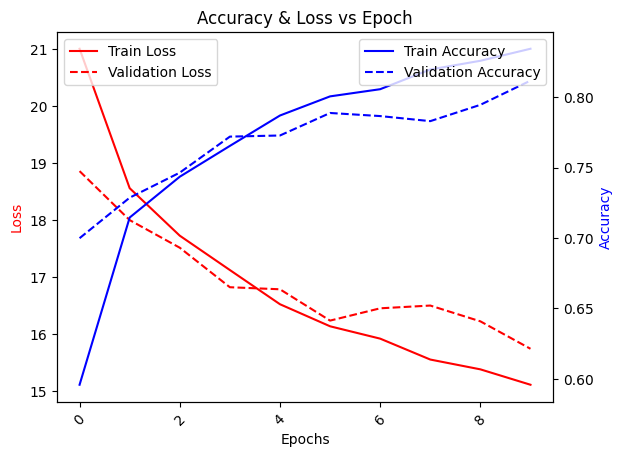

In [ ]:
# epoch_log = [*range(epochs)]

# # To create a plot with secondary y-axis we need to create a subplot
# fig, ax1 = plt.subplots()

# # Set title and x-axis label rotation
# plt.title("Accuracy & Loss vs Epoch")
# plt.xticks(rotation=45)

# # We use twinx to create a plot a secondary y axis
# ax2 = ax1.twinx()

# # Create plot for loss_log and accuracy_log
# ax1.plot(epoch_log, train_loss, 'r-')
# ax2.plot(epoch_log, train_accuracy, 'b-')

# # Create plot for loss_log and accuracy_log
# ax1.plot(epoch_log, val_loss, 'r-')
# ax2.plot(epoch_log, val_accuarcy, 'b-')

# # Set labels
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss', color='r')
# ax2.set_ylabel('Test Accuracy', color='b')

# plt.show()
epoch_log = [*range(epochs)]

# Create a subplot with a secondary y-axis
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot training loss and accuracy
ax1.plot(epoch_log, train_loss, 'r-', label='Train Loss')
ax2.plot(epoch_log, train_accuracy, 'b-', label='Train Accuracy')

# Plot validation loss and accuracy
ax1.plot(epoch_log, val_loss, 'r--', label='Validation Loss')  # Dashed line for distinction
ax2.plot(epoch_log, val_accuracy, 'b--', label='Validation Accuracy')  # Fixed typo here

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy', color='b')

# Add legends (optional but improves readability)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

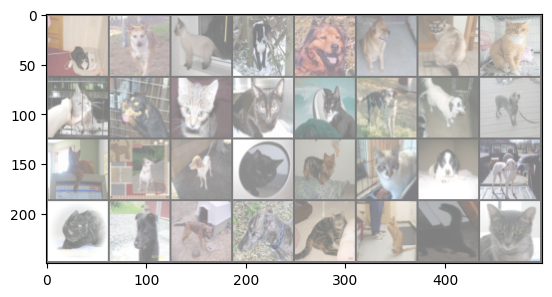

GroundTruth:  01011100010001110110101101110000


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Loading one mini-batch
dataiter = iter(val_dataset)
images, labels = next(dataiter)

# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(32)))

In [ ]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = CNN()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
samples, _ = iter(next(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

TypeError: 'DataLoader' object is not an iterator